In [ ]:
# This notebook is to make Figure 3 of Rodgers et al. 2021 (https://doi.org/10.5194/esd-2021-50). 
# If you have have any questions, please contact the author of this notebook.
# Author: Ryohei Yamaguchi (ryamaguchi  at  pusan.ac.kr)

# Wavelet power spectrum is calculated from another notobook by Karl J. Stein (steinkarl  at  pusan.ac.kr) 

In [1]:
## mpirun --np 6 dask-mpi --scheduler-file scheduler.json --no-nanny --dashboard-address :8785 --memory-limit=60e9
from dask.distributed import Client
client = Client(scheduler_file='/proj/ryamaguchi/Dask/run_2/scheduler.json')
client

Client Scheduler: tcp://203.247.189.225:42960 Dashboard: http://203.247.189.225:8786/status,Cluster Workers: 8 Cores: 144 Memory: 480.00 GB


### Import

In [39]:
%matplotlib inline

import numpy as np
import xarray as xr
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import matplotlib.gridspec as gridspec 
import cartopy.crs as ccrs
import cartopy.feature as cf
from cmcrameri import cm
import cmaps

import glob
import os 
import string
from datetime import datetime
today = datetime.today()
def sel_mon(month,smon,emon) :
    return (month>=smon) & (month<=emon)

from tqdm.notebook import tqdm_notebook

In [2]:
def xarray_trend(xarr):    
    from scipy import stats
    
    m = np.prod(xarr.shape[1:]).squeeze()
    n = xarr.shape[0]
    
    x = xarr.year.values[:, None]
    y = xarr.to_masked_array().reshape(n, -1)
    
    xm = x.mean(0)  # mean
    ym = y.mean(0)  # mean
    ya = y - ym  # anomaly
    xa = x - xm  # anomaly
    
    xss = (xa ** 2).sum(0) / (n - 1)  # variance of x (with df as n-1)
    yss = (ya ** 2).sum(0) / (n - 1)  # variance of y (with df as n-1)
    xys = (xa * ya).sum(0) / (n - 1)  # covariance (with df as n-1)

    slope = xys / xss
    intercept = ym - (slope * xm)

    df = n - 2
    r = xys / (xss * yss)**0.5
    t = r * (df / ((1 - r) * (1 + r)))**0.5
    p = stats.distributions.t.sf(abs(t), df)
    
    out = xarr[:2].mean('year')
    xarr_slope = out.copy()
    xarr_slope.name = 'slope'
    xarr_slope.attrs['units'] = 'units / year'
    xarr_slope.values = slope.reshape(xarr.shape[1:])

    xarr_p = out.copy()
    xarr_p.name = 'Pvalue'
    xarr_p.attrs['info'] = "If p < 0.05 then the results from 'slope' are significant."
    xarr_p.values = p.reshape(xarr.shape[1:])

    xarr_out = xarr_slope.to_dataset(name='slope')
    xarr_out['pval'] = xarr_p
    return xarr_out

### Read

In [3]:
VAR = ['PRECT','TS']

scenarios=('HIST','SSP370')
members_cmip=('1001.001','1021.002','1041.003','1061.004','1081.005','1101.006','1121.007','1141.008','1161.009','1181.010',
              '1231.001','1231.002','1231.003','1231.004','1231.005','1231.006','1231.007','1231.008','1231.009','1231.010',
              '1251.001','1251.002','1251.003','1251.004','1251.005','1251.006','1251.007','1251.008','1251.009','1251.010',
              '1281.001','1281.002','1281.003','1281.004','1281.005','1281.006','1281.007','1281.008','1281.009','1281.010',
              '1301.001','1301.002','1301.003','1301.004','1301.005','1301.006','1301.007','1301.008','1301.009','1301.010')
members_smbb=('1011.001','1031.002','1051.003','1071.004','1091.005','1111.006','1131.007','1151.008','1171.009','1191.010',
              '1231.011','1231.012','1231.013','1231.014','1231.015','1231.016','1231.017','1231.018','1231.019','1231.020',
              '1251.011','1251.012','1251.013','1251.014','1251.015','1251.016','1251.017','1251.018','1251.019','1251.020',
              '1281.011','1281.012','1281.013','1281.014','1281.015','1281.016','1281.017','1281.018','1281.019','1281.020',
              '1301.011','1301.012','1301.013','1301.014','1301.015','1301.016','1301.017','1301.018','1301.019','1301.020')
members=members_cmip+members_smbb
ensembles = [ens for ens in range(len(members))]

In [4]:
exceptcv=['time','lon','lat',*VAR]
def process_coords(ds, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]
          
    if drop:
        return ds.drop(coord_vars)
    else:
        return ds.set_coords(coord_vars)

In [5]:
time='day_1'

file_list_hist=[]
file_list_ssp3=[]
for var in VAR :
    ens_files_hist=[]
    ens_files_ssp3=[]
    for member in members :
        files_hist=[]    
        files_ssp3=[]    
        for scenario in scenarios :
            files=[]
            comp,model='atm','cam.h1'
            in_dir = '/proj/jedwards/archive/b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'/'+comp+'/proc/tseries/'+time+'/'
            fn = 'b.e21.B'+scenario+'*.f09_g17.LE2-'+member+'.'+model+'.'+var+'.*.nc'
            files += glob.glob(in_dir+fn)
            if scenario=='HIST'  : files_hist = sorted(files)
            if scenario=='SSP370': files_ssp3 = sorted(files)
        ens_files_hist.append(files_hist)
        ens_files_ssp3.append(files_ssp3)
    file_list_hist.append(ens_files_hist) 
    file_list_ssp3.append(ens_files_ssp3) 

for i in range(len(VAR)):
    print(i,VAR[i],len(file_list_hist[i]),len(file_list_hist[i][-1]),len(file_list_ssp3[i][-1]))

0 PRECT 100 17 9
1 TS 100 17 9


In [ ]:
ds_0_hist=xr.open_mfdataset(file_list_hist[0],chunks={'time':100},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_0_ssp3=xr.open_mfdataset(file_list_ssp3[0],chunks={'time':100},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)

ds_1_hist=xr.open_mfdataset(file_list_hist[1],chunks={'time':100},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)
ds_1_ssp3=xr.open_mfdataset(file_list_ssp3[1],chunks={'time':100},combine='nested',concat_dim=[[*ensembles],'time'],parallel='True',
                       preprocess=process_coords,decode_cf=True,decode_times=True)

In [ ]:
PRECT=xr.concat([ds_0_hist.PRECT.isel( time=slice(1,len(ds_0_hist.time))),ds_0_ssp3.PRECT.isel( time=slice(1,len(ds_0_ssp3.time)))],dim='time')
TS   =xr.concat([ds_1_hist.TS.isel(time=slice(1,len(ds_1_hist.time)))    ,ds_1_ssp3.TS.isel(time=slice(1,len(ds_1_ssp3.time)))],dim='time')

time_new=xr.cftime_range(start='1850',end='2100-12-31',freq='1D',calendar='noleap')

PRECT=PRECT.assign_coords(time=time_new)
TS=TS.assign_coords(time=time_new)

ds_0 = PRECT.to_dataset()
ds_1 = TS.to_dataset()

In [ ]:
ds_0

### Calc time series (nino 3.4)

In [ ]:
slon,elon=190,240
slat,elat=-5,5

ds_0.PRECT.isel(concat_dim=0,time=0).sel(lat=slice(slat,elat),lon=slice(slon,elon)).plot()
plt.show()

In [ ]:
for i in tqdm_notebook(range(len(members))):
    nino34_p_t = ds_0[VAR[0]].isel(concat_dim=i).sel(lat=slice(slat,elat),lon=slice(slon,elon)).mean(('lon','lat'),skipna=True).load()
    if i==0: nino34_p=nino34_p_t
    if i!=0: nino34_p=xr.concat([nino34_p,nino34_p_t],dim='concat_dim')

In [ ]:
for i in tqdm_notebook(range(len(members))):
    nino34_t_t = ds_1[VAR[1]].isel(concat_dim=i).sel(lat=slice(slat,elat),lon=slice(slon,elon)).mean(('lon','lat'),skipna=True).load()
    if i==0: nino34_t=nino34_t_t
    if i!=0: nino34_t=xr.concat([nino34_t,nino34_t_t],dim='concat_dim')

In [ ]:
UC=(1e3)*(60.*60.*24.*365.)

mean=(UC*nino34_p).groupby('time.year').mean().mean('concat_dim')
std=(UC*nino34_p).groupby('time.year').mean().std('concat_dim')
mean.plot.line(x='year',linewidth=1,color='red',add_legend=False)
plt.fill_between(std.year,mean-std,mean+std,alpha=0.3,linewidth=0,color='gray')
plt.show()

In [ ]:
mean=(nino34_t-273.15).groupby('time.year').mean().mean('concat_dim')
std=(nino34_t-273.15).groupby('time.year').mean().std('concat_dim')
mean.plot.line(x='year',linewidth=1,color='red',add_legend=False)
plt.fill_between(std.year,mean-std,mean+std,alpha=0.3,linewidth=0,color='gray')
plt.show()
plt.show()

### write

In [18]:
print(VAR[0],ds_0[VAR[0]].units)
print(VAR[1],ds_1[VAR[1]].units)

PRECT m/s
TS K


In [21]:
paths=[]
for i in range(2):
    if i==0 : ds,da_w,unit=ds_0,nino34_p,ds_0[VAR[i]].units
    if i==1 : ds,da_w,unit=ds_1,nino34_t,ds_1[VAR[i]].units

    vname=VAR[i]
    out_dir='/proj/ryamaguchi/CESM2_LENS/time.series/'
    fn=today.strftime("%y%m%d")+'_Nino34.daily_'+VAR[i]+'.%s-members.nc' %len(members)

    da_w.name=vname
    ds_w=da_w.to_dataset()
    ds_w=ds_w.rename({'concat_dim':'ensemble'})
    ds_w=ds_w.assign_coords(ensemble=[*members])
    ds_w[vname].attrs['units']        = unit
    ds_w[vname].attrs['long_name']    = "Nino34 %s" %VAR[i]
#    ds_w[vname].attrs['_FillValue']   = ds[VAR[i]].encoding['_FillValue']
#    ds_w[vname].attrs['missing_value']= ds[VAR[i]].encoding['missing_value']
    ds_w.attrs['history']="%s members, script path: %s, made by ryamaguchi" %(len(members),os.getcwd())

    ds_w.to_netcdf(path=out_dir+fn, mode="w",format="NETCDF4_CLASSIC" )
    paths+=[out_dir+fn]

In [22]:
paths

['/proj/ryamaguchi/CESM2_LENS/time.series/210607_Nino34.daily_PRECT.100-members.nc',
 '/proj/ryamaguchi/CESM2_LENS/time.series/210607_Nino34.daily_TS.100-members.nc']

### Figure

In [11]:
nino34_p=xr.open_dataset('/proj/ryamaguchi/CESM2_LENS/time.series/210607_Nino34.daily_PRECT.100-members.nc')
nino34_t=xr.open_dataset('/proj/ryamaguchi/CESM2_LENS/time.series/210607_Nino34.daily_TS.100-members.nc')
nino34_p

<xarray.Dataset>
Dimensions:   (ensemble: 100, time: 91615)
Coordinates:
  * time      (time) object 1850-01-01 00:00:00 ... 2100-12-31 00:00:00
  * ensemble  (ensemble) object '1001.001' '1021.002' ... '1301.019' '1301.020'
Data variables:
    PRECT     (ensemble, time) float32 ...
Attributes:
    history:  100 members, script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl...

In [12]:
UCp=1e3*60*60*24
UCt=273.13

nino34_t_ann=(nino34_t.TS-UCt).groupby('time.year').mean()
nino34_p_ann=(nino34_p.PRECT*UCp).groupby('time.year').mean()
nino34_t_ann

<xarray.DataArray 'TS' (ensemble: 100, year: 251)>
array([[27.51249 , 26.27413 , 25.526552, ..., 31.088476, 31.898962,
        31.594711],
       [27.426964, 27.188774, 26.620554, ..., 31.71848 , 30.8983  ,
        32.452057],
       [26.401129, 26.634539, 27.870481, ..., 32.199368, 30.123775,
        31.218462],
       ...,
       [27.913153, 27.236103, 26.627234, ..., 31.180271, 32.01521 ,
        31.032816],
       [28.074762, 28.087727, 27.51063 , ..., 32.290638, 32.449497,
        31.663532],
       [26.986818, 25.866182, 26.129436, ..., 31.597883, 31.166452,
        31.823809]], dtype=float32)
Coordinates:
  * ensemble  (ensemble) object '1001.001' '1021.002' ... '1301.019' '1301.020'
  * year      (year) int64 1850 1851 1852 1853 1854 ... 2096 2097 2098 2099 2100

In [13]:
x = np.arange(1850+1,2100+1)
y = np.arange(1,366)
ind = pd.MultiIndex.from_product((x,y),names=('year','day'))
nino34_p_yr = nino34_p.isel(time=slice(365-31,91615-31)).assign(time=ind).unstack('time')
nino34_t_yr = nino34_t.isel(time=slice(365-31,91615-31)).assign(time=ind).unstack('time')
nino34_t_yr

<xarray.Dataset>
Dimensions:   (day: 365, ensemble: 100, year: 250)
Coordinates:
  * ensemble  (ensemble) object '1001.001' '1021.002' ... '1301.019' '1301.020'
  * year      (year) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100
  * day       (day) int64 1 2 3 4 5 6 7 8 9 ... 358 359 360 361 362 363 364 365
Data variables:
    TS        (ensemble, year, day) float32 301.0 301.0 301.0 ... 306.1 306.1
Attributes:
    history:  100 members, script path: /mnt/lustre/proj/ryamaguchi/03.prj_cl...

In [34]:
nino34_t_djf=(nino34_t_yr.TS-UCt).isel(day=slice(0,90)).mean('day')
nino34_p_djf=(nino34_p_yr.PRECT*UCp).isel(day=slice(0,90)).mean('day')
nino34_t_jja=(nino34_t_yr.TS-UCt).isel(day=slice(182,274)).mean('day')
nino34_p_jja=(nino34_p_yr.PRECT*UCp).isel(day=slice(182,274)).mean('day')
nino34_t_djf

<xarray.DataArray 'TS' (ensemble: 100, year: 250)>
array([[28.451738, 24.29528 , 25.628506, ..., 31.774355, 31.329624,
        33.132805],
       [27.935911, 26.217554, 25.71505 , ..., 30.440577, 32.878086,
        30.015022],
       [25.17828 , 27.10608 , 28.43822 , ..., 29.986773, 33.13256 ,
        29.270863],
       ...,
       [28.541222, 25.819176, 27.330935, ..., 31.651548, 30.456858,
        33.52288 ],
       [28.244335, 27.327663, 27.631836, ..., 32.131462, 32.52704 ,
        32.71345 ],
       [25.672243, 24.644146, 25.885515, ..., 28.76321 , 33.15711 ,
        29.95571 ]], dtype=float32)
Coordinates:
  * ensemble  (ensemble) object '1001.001' '1021.002' ... '1301.019' '1301.020'
  * year      (year) int64 1851 1852 1853 1854 1855 ... 2096 2097 2098 2099 2100

In [35]:
em_t=(nino34_t_yr.TS-UCt).mean('ensemble')
es_t=(nino34_t_yr.TS-UCt).std('ensemble')
em_p=(nino34_p_yr.PRECT*UCp).mean('ensemble')
es_p=(nino34_p_yr.PRECT*UCp).std('ensemble')

In [36]:
wave_ds = xr.open_dataset('/proj/kstein/CESM2_LE/Presentation_paper/output/Nino34/CESM2_LENS_Nino34_TS_PRECT_wavelets.nc')
wave_ds

<xarray.Dataset>
Dimensions:   (period: 41, time: 1680)
Coordinates:
  * time      (time) float64 1.96e+03 1.96e+03 1.96e+03 ... 2.1e+03 2.1e+03
  * period    (period) float64 0.5165 0.5633 0.6143 0.6698 ... 13.9 15.16 16.53
Data variables:
    ts_power  (time, period) float64 ...
    p_power   (time, period) float64 ...
    coi       (time) float64 ...
Attributes:
    description:  CESM2 LENS Niño3.4 TS,PRECT wavelets.

/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: The 'subsy' parameter of __init__() has been renamed 'subs' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
/home/ryamaguchi/.conda/envs/geoview/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: The 'subsy' parameter of __init__() has been renamed 'subs' since Mat

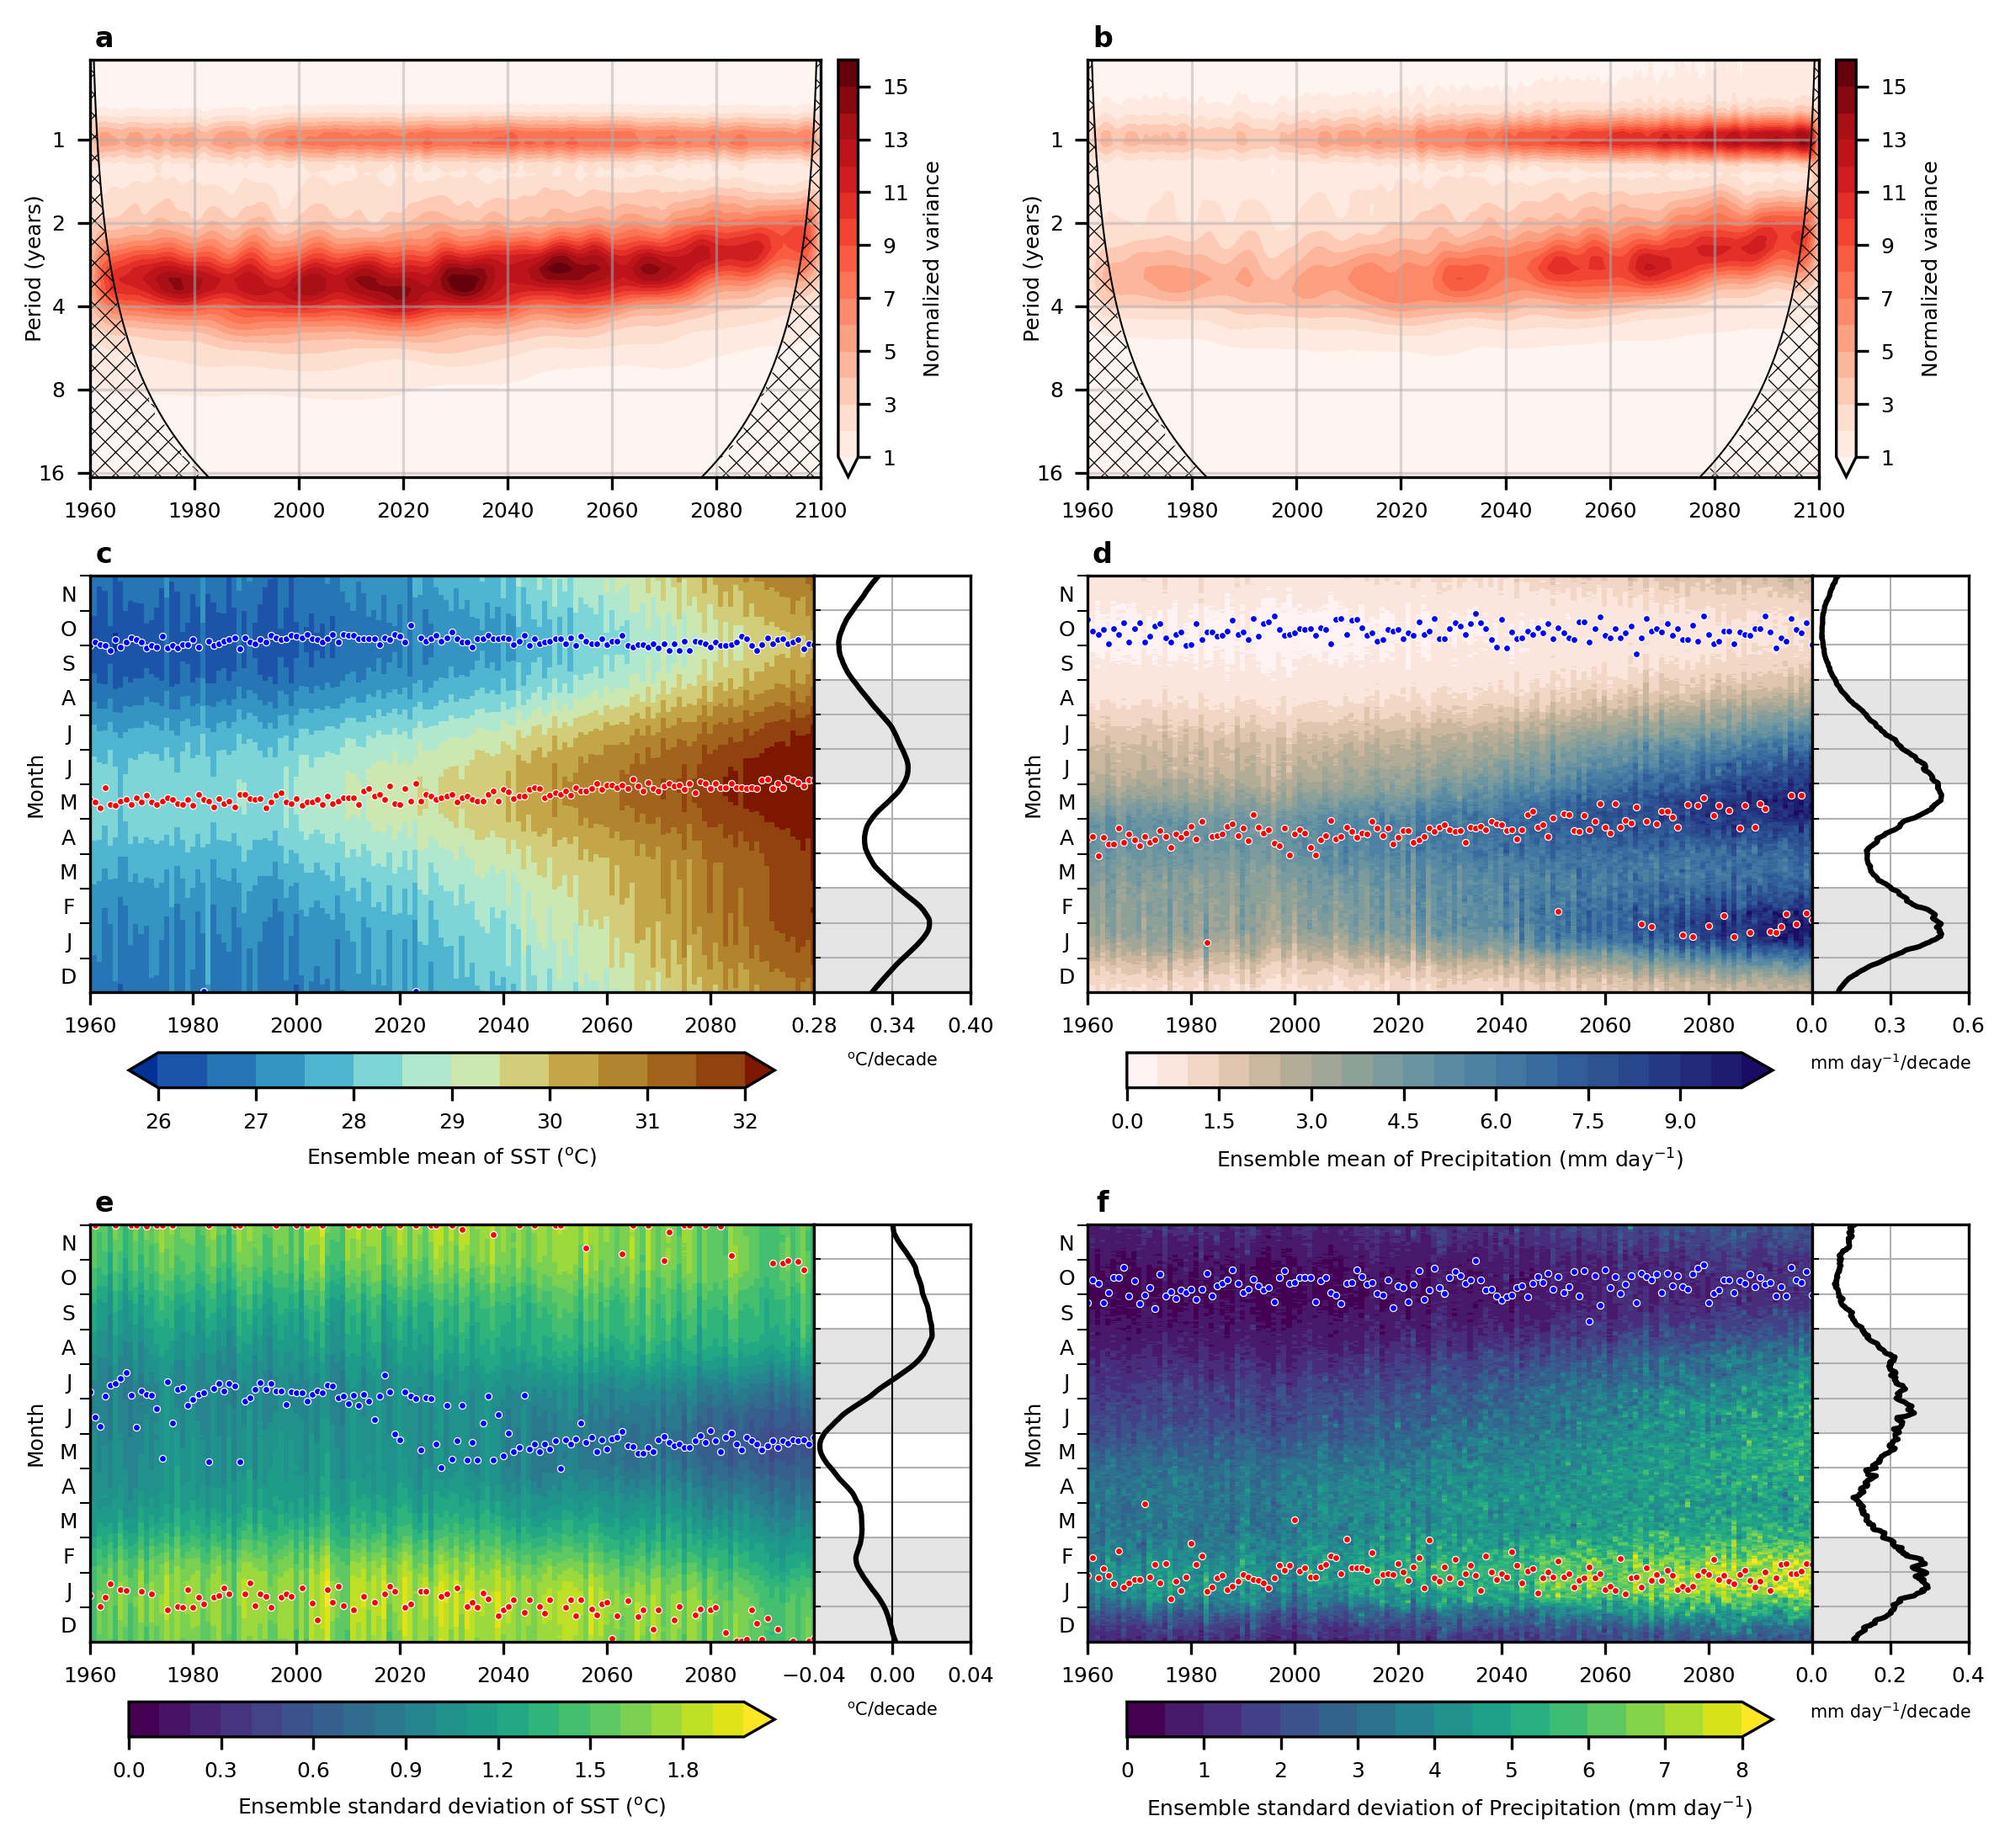

In [41]:
syr,eyr=1960,2100

trend_t_em=xarray_trend(em_t.sel(year=slice(syr,eyr)).load())
trend_t_es=xarray_trend(es_t.sel(year=slice(syr,eyr)).load())
trend_p_em=xarray_trend(em_p.sel(year=slice(syr,eyr)).load())
trend_p_es=xarray_trend(es_p.sel(year=slice(syr,eyr)).load())

trend_t_em_ann=xarray_trend(nino34_t_ann.mean('ensemble').sel(year=slice(syr,eyr)).load())
trend_t_es_ann=xarray_trend(nino34_t_ann.std( 'ensemble').sel(year=slice(syr,eyr)).load())
trend_p_em_ann=xarray_trend(nino34_p_ann.mean('ensemble').sel(year=slice(syr,eyr)).load())
trend_p_es_ann=xarray_trend(nino34_p_ann.std( 'ensemble').sel(year=slice(syr,eyr)).load())
trend_t_em_jja=xarray_trend(nino34_t_jja.mean('ensemble').sel(year=slice(syr,eyr)).load())
trend_t_es_jja=xarray_trend(nino34_t_jja.std( 'ensemble').sel(year=slice(syr,eyr)).load())
trend_p_em_jja=xarray_trend(nino34_p_jja.mean('ensemble').sel(year=slice(syr,eyr)).load())
trend_p_es_jja=xarray_trend(nino34_p_jja.std( 'ensemble').sel(year=slice(syr,eyr)).load())
trend_t_em_djf=xarray_trend(nino34_t_djf.mean('ensemble').sel(year=slice(syr,eyr)).load())
trend_t_es_djf=xarray_trend(nino34_t_djf.std( 'ensemble').sel(year=slice(syr,eyr)).load())
trend_p_em_djf=xarray_trend(nino34_p_djf.mean('ensemble').sel(year=slice(syr,eyr)).load())
trend_p_es_djf=xarray_trend(nino34_p_djf.std( 'ensemble').sel(year=slice(syr,eyr)).load())


hat=xr.full_like(wave_ds.ts_power,0)
hat=xr.where(hat.period>wave_ds.coi, 0, 1)

#----------------------------------------------------------------------------------------------
plt.rcParams.update({'font.size': 6,'hatch.linewidth': 0.3})
fig = plt.figure(figsize=(10,10),dpi=300,facecolor='w', edgecolor='k')
gs  = gridspec.GridSpec(100,100,figure=fig,wspace=0)
ax=[]
ax.append(fig.add_subplot(gs[ 2:24, 2:47]))    
ax.append(fig.add_subplot(gs[ 2:24,53:98]))
ax.append(fig.add_subplot(gs[29:51, 2:39]))    
ax.append(fig.add_subplot(gs[29:51,39:47]))
ax.append(fig.add_subplot(gs[29:51,53:90]))
ax.append(fig.add_subplot(gs[29:51,90:98]))

ax.append(fig.add_subplot(gs[63:85, 2:39]))
ax.append(fig.add_subplot(gs[63:85,39:47]))
ax.append(fig.add_subplot(gs[63:85,53:90]))
ax.append(fig.add_subplot(gs[63:85,90:98]))
ax.append(fig.add_subplot(gs[54:56, 4:37]))    
ax.append(fig.add_subplot(gs[54:56,55:88]))    
ax.append(fig.add_subplot(gs[88:90, 4:37]))    
ax.append(fig.add_subplot(gs[88:90,55:88]))    
#----------------------------------------------------------------------------------------------

cbar_kwargs={'pad':0.02,'label':'Normalized variance'}

wave_ds.ts_power.plot.contourf(ax=ax[0],x='time',y='period',levels=np.arange(1,17),cmap=plt.cm.Reds,cbar_kwargs=cbar_kwargs)
hat.plot.contourf(ax=ax[0],levels=[-1,0],hatches=['xxxx',None,None],add_colorbar=False,alpha=0)
wave_ds.coi.plot(ax=ax[0],linewidth=0.5,color='black')

wave_ds.p_power.plot.contourf(ax=ax[1],x='time',y='period',levels=np.arange(1,17),cmap=plt.cm.Reds,cbar_kwargs=cbar_kwargs)
hat.plot.contourf(ax=ax[1],levels=[-1,0],hatches=['xxxx',None,None],add_colorbar=False,alpha=0)
wave_ds.coi.plot(ax=ax[1],linewidth=0.5,color='black')

for i in range(2):
    ax[i].set_yscale('log', basey=2, subsy=None)
#    ax[i].invert_yaxis()
    ax[i].yaxis.set_major_formatter(ticker.ScalarFormatter())
    ax[i].yaxis.set_major_formatter(ticker.FormatStrFormatter('%.0f'))
    ax[i].set_xticks(np.arange(syr,eyr+1,20))
    ax[i].set_ylabel('Period (years)',labelpad=-2)
    ax[i].set_xlabel('')
    ax[i].set_ylim([np.max(wave_ds.period),np.min(wave_ds.period)])
    ax[i].set_xlim(syr,eyr)
    ax[i].grid(True,alpha=.5)
    ax[i].text(0.02,1.05,'%s'%list(string.ascii_lowercase)[i], fontsize = 8, ha='center', va='center', fontweight='bold', transform=ax[i].transAxes)

#----------------------------------------------------------------------------------------------

ctem=em_t.sel(year=slice(syr,eyr)).plot(ax=ax[2],x='year',y='day',add_colorbar=False,cmap=cm.roma_r,levels=np.linspace(26,32,13))
ax[2].scatter(np.arange(syr,eyr+1),em_t.idxmax('day').sel(year=slice(syr,eyr)),marker='.',color='red',s=15,edgecolor='white',linewidth=.3)
ax[2].scatter(np.arange(syr,eyr+1),em_t.idxmin('day').sel(year=slice(syr,eyr)),marker='.',color='blue',s=15,edgecolor='white',linewidth=.3)
(10.*trend_t_em).slope.plot(ax=ax[3],y='day',color='black',linewidth=1.5,zorder=10)

cpem=em_p.sel(year=slice(syr,eyr)).plot(ax=ax[4],x='year',y='day',add_colorbar=False,cmap=cm.lapaz_r,levels=np.linspace(0,10,21))
ax[4].scatter(np.arange(syr,eyr+1),em_p.idxmax('day').sel(year=slice(syr,eyr)),marker='.',color='red',s=15,edgecolor='white',linewidth=.3)
ax[4].scatter(np.arange(syr,eyr+1),em_p.idxmin('day').sel(year=slice(syr,eyr)),marker='.',color='blue',s=15,edgecolor='white',linewidth=.3)
(10.*trend_p_em).slope.plot(ax=ax[5],y='day',color='black',linewidth=1.5,zorder=10)

ctes=es_t.sel(year=slice(syr,eyr)).plot(ax=ax[6],x='year',y='day',add_colorbar=False,cmap=cmaps.MPL_viridis,levels=np.linspace(0,2,21))
ax[6].scatter(np.arange(syr,eyr+1),es_t.idxmax('day').sel(year=slice(syr,eyr)),marker='.',color='red',s=15,edgecolor='white',linewidth=.3)
ax[6].scatter(np.arange(syr,eyr+1),es_t.idxmin('day').sel(year=slice(syr,eyr)),marker='.',color='blue',s=15,edgecolor='white',linewidth=.3)
(10.*trend_t_es).slope.plot(ax=ax[7],y='day',color='black',linewidth=1.5,zorder=10)

cpes=es_p.sel(year=slice(syr,eyr)).plot(ax=ax[8],x='year',y='day',add_colorbar=False,cmap=cmaps.MPL_viridis,levels=np.linspace(0,8,17))
ax[8].scatter(np.arange(syr,eyr+1),es_p.idxmax('day').sel(year=slice(syr,eyr)),marker='.',color='red',s=15,edgecolor='white',linewidth=.3)
ax[8].scatter(np.arange(syr,eyr+1),es_p.idxmin('day').sel(year=slice(syr,eyr)),marker='.',color='blue',s=15,edgecolor='white',linewidth=.3)
(10.*trend_p_es).slope.plot(ax=ax[9],y='day',color='black',linewidth=1.5,zorder=10)

titles1=['Ensemble mean','Ensemble standard deviation']
titles2=['SST','Precipitation']
units=['$^{\mathrm{o}}$C','mm day$^{-1}$']

cb0 = plt.colorbar(ctem, cax = ax[10],orientation='horizontal')
cb1 = plt.colorbar(cpem, cax = ax[11],orientation='horizontal')
cb2 = plt.colorbar(ctes, cax = ax[12],orientation='horizontal')
cb3 = plt.colorbar(cpes, cax = ax[13],orientation='horizontal')
cb0.set_label('%s of %s (%s)'%(titles1[0],titles2[0],units[0]))
cb1.set_label('%s of %s (%s)'%(titles1[0],titles2[1],units[1]))
cb2.set_label('%s of %s (%s)'%(titles1[1],titles2[0],units[0]))
cb3.set_label('%s of %s (%s)'%(titles1[1],titles2[1],units[1]))

xlims=[[0.28,0.4],[0.0,0.6],[-0.04,0.04],[0,0.4]]
xtickss=[[0.28,0.34,0.4],[0,0.3,0.6],[-0.04,0,0.04],[0,0.2,0.4]]

j,k=0,0
for i,a in enumerate(ax):
    if i<2 or i>=10: continue
    if i%2==0:
        a.text(0.02,1.05,'%s'%list(string.ascii_lowercase)[j+2], fontsize = 8, ha='center', va='center', fontweight='bold', transform=a.transAxes)
        a.set_xlabel('')
        a.set_ylabel('Month')        
        a.set_yticks(np.linspace(365./12/2,365-365./12/2,12))
        a.set_yticklabels(np.roll(['J','F','M','A','M','J','J','A','S','O','N','D'],1),ha='center')
        a.yaxis.set_minor_locator(ticker.MultipleLocator(365/12))
        a.tick_params(axis='y',which='major',length=0,pad=6)
        a.tick_params(axis='y',which='minor',length=3,width=.5) 
        a.set_xticks(np.arange(syr,eyr,20))
        a.set_xlim(syr,eyr)
        j=j+1
    else:
        a.set_ylim(0,365)
        a.set_yticks(np.linspace(0,365,13))
        a.set_xticks(xtickss[k])
        a.tick_params(axis="y",direction="in")
        a.set_ylabel('')
        a.set_xlabel('%s/decade'%units[k%2],fontsize=5)
        a.tick_params(axis='y',which='major',length=2,width=0.5,pad=6)
        a.set_yticklabels([])
#        a.axhspan(365/12*6.,365/12*9.,linewidth=0,color='darkorange',alpha=0.1)
#        a.axhspan(365/12*0.,365/12*3.,linewidth=0,color='green'     ,alpha=0.1)
        a.axhspan(365/12*6.,365/12*9.,linewidth=0,color='gray',alpha=0.2)
        a.axhspan(365/12*0.,365/12*3.,linewidth=0,color='gray',alpha=0.2)
        a.grid(linewidth=0.5)
        a.set_xlim(xlims[k][0],xlims[k][1])
        if k==2: a.vlines([0],0,365,color='black',linewidth=0.5)
        k=k+1
    
plt.show()
fig.savefig('/home/ryamaguchi/tmp_fig/pp_fig_3_100-members_'+today.strftime("%y%m%d")+'.pdf')